# Benchmarks

In [1]:
import logging
import os

logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import plb

In [4]:
pd.set_option('display.max_colwidth', None)

In [5]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [6]:
INPUT_DIR='/storage/m2/market_data/raw/crypto/binance/BTCUSDT/orderbook'
OUTPUT_PQ='output2.parquet'
SAMPLE_DATE='2020-11-01'

## Price Levels Book (PLB) helper functions

In [7]:
def get_input_pair(input_dir, dt):
    '''Load Binance L2 orderbook snapshot and delta files'''
    fn_template = os.path.join(input_dir, 'BTCUSDT_T_DEPTH_{}_depth_'.format(dt))
    snap_fn = fn_template + 'snap.csv'
    update_fn = fn_template + 'update.csv'
    
    return pd.read_csv(snap_fn), pd.read_csv(update_fn)

In [8]:
def get_l2_input(input_dir, dt):
    '''Pre-process input'''
    snapshot, deltas = get_input_pair(input_dir, dt)
    
    df = pd.concat([snapshot,deltas])

    df['side'] = np.where(df['side'] == 'b', 1, 0)
    df['side'] = df['side'].astype('int8')

    df['qty'] = df['qty'].astype('float32')

    df = df.drop(columns=['symbol', 'first_update_id', 'last_update_id', 'update_type'])
    
    return df, snapshot.shape[0]

## Naive Python/Numpy implementation

In [9]:
def apply_side(p_prices, p_qtys, price, qty):
    pos = np.searchsorted(p_prices, price)

    if price not in p_prices:
        p_prices = np.insert(p_prices, pos, price)
        p_qtys = np.insert(p_qtys, pos, qty)
    else:
        if qty == 0.0:
            p_prices = np.delete(p_prices, pos)
            p_qtys = np.delete(p_qtys, pos)
        else:
            p_qtys[pos] = qty

    return p_prices, p_qtys
    
def l2_walk_naive(data, top_n):

    bid_prices, bid_qtys = np.array([]), np.array([])
    ask_prices, ask_qtys = np.array([]), np.array([])
    out = []

    for ts, side, price, qty in data:
        
        if side == 1:
            bid_prices, bid_qtys = apply_side(bid_prices, bid_qtys, price, qty)
        else:
            ask_prices, ask_qtys = apply_side(ask_prices, ask_qtys, price, qty)
            
        top_bids = np.stack((bid_prices[-top_n:], bid_qtys[-top_n:])).flatten(order='F')
        top_asks = np.stack((bid_prices[:top_n], bid_qtys[:top_n])).flatten(order='F')
        
        _out = np.concatenate((top_bids, top_asks))
        out.append(_out)

    return out

In [10]:
df, snapshot_end_off_t = get_l2_input(INPUT_DIR, SAMPLE_DATE)

data =  df[['timestamp', 'side', 'price', 'qty']] \
    .head(100000) \
    .values

### Time naive implementation

In [11]:
%%timeit -o 

ret = l2_walk_naive(data, 8)

5.12 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 5.12 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [12]:
timings = _
naive_t = np.mean(timings.timings)
naive_t

5.122296140707996

### Time plb C++ implementation

In [13]:
%%timeit -o 

ret = plb.l2_walk(data[:,0].astype(int), data[:,1].astype(int), data[:,2], data[:,3])

44.6 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 44.6 ms ± 413 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [14]:
timings = _
plb_t = np.mean(timings.timings)
plb_t

0.04462352888492336

### Time plb C++ implementation + track qtys within $50 of mid

In [15]:
%%timeit -o 

ret = plb.l2_walk(data[:,0].astype(int), data[:,1].astype(int), data[:,2], data[:,3], total_dollar_depth=50)

326 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 326 ms ± 1.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [16]:
timings = _
plb_t_d50 = np.mean(timings.timings)
plb_t_d50

0.32581449742844726

### Time plb C++ implementation + track qtys within $100 of mid

In [17]:
%%timeit -o 

ret = plb.l2_walk(data[:,0].astype(int), data[:,1].astype(int), data[:,2], data[:,3], total_dollar_depth=100)

620 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 620 ms ± 1.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [18]:
timings = _
plb_t_d100 = np.mean(timings.timings)
plb_t_d100

0.6197902988476146

# Plots

In [19]:
results = pd.DataFrame.from_dict({
    'Implementation': ['naive', 'plb', 'plb50', 'plb100'],
    'Avg. Time (Secs)': [naive_t, plb_t, plb_t_d50, plb_t_d100]
})
results

,Implementation,Avg. Time (Secs)
0,naive,5.122296
1,plb,0.044624
2,plb50,0.325814
3,plb100,0.619790


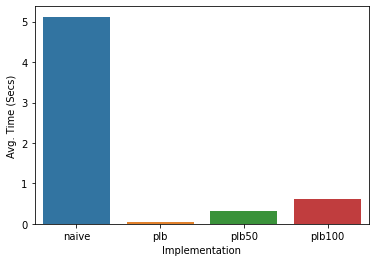

In [20]:
ax = sns.barplot(x=results['Implementation'], y=results['Avg. Time (Secs)'])
fig = ax.get_figure()
fig.savefig('benchmarks.png')

In [22]:
5.122296/0.325814

15.721534372371968

In [23]:
5.122296/0.619790

8.264567030768488